In [186]:
import pandas as pd 
import numpy as np 
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.io import read_image
import warnings
from torchvision import transforms, models

In [187]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Neural Networks Laboratory

## Dataset

In [188]:
class CustomImageDataset(Dataset):
    
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.to_pil = transforms.ToPILImage()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):


        label = torch.tensor(self.img_labels.iloc[idx, 1:].astype(float).values, dtype=torch.float32)

        img_name = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
                

        image = read_image(img_name)
        

        if self.transform:
            image = self.transform(self.to_pil(image))

        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    

In [189]:
folder = os.path.join('data', 'screenshots')

In [190]:
ScreenDataset = CustomImageDataset(annotations_file=os.path.join(folder, 'image_labels.csv'), img_dir=os.path.join(folder))

In [191]:
train_size = 0.8 

train_dataset, test_dataset = torch.utils.data.random_split(ScreenDataset, [train_size, 1-train_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [192]:
next(iter(train_dataloader))

[tensor([[[[ 48,  60, 112,  ..., 145, 136, 136],
           [102, 128, 150,  ..., 129, 118, 116],
           [169, 174, 153,  ..., 107,  97,  95],
           ...,
           [215, 212, 214,  ..., 237, 245, 244],
           [210, 210, 211,  ..., 255, 255, 255],
           [216, 215, 214,  ..., 255, 255, 255]],
 
          [[ 32,  45,  95,  ..., 179, 171, 171],
           [ 95, 121, 140,  ..., 170, 159, 160],
           [178, 182, 156,  ..., 163, 153, 153],
           ...,
           [116, 113, 115,  ..., 181, 189, 190],
           [111, 111, 112,  ..., 208, 207, 207],
           [117, 116, 115,  ..., 205, 207, 207]],
 
          [[  6,  12,  49,  ..., 181, 175, 175],
           [ 49,  69,  81,  ..., 172, 163, 163],
           [ 95,  97,  69,  ..., 162, 154, 154],
           ...,
           [ 85,  82,  83,  ..., 156, 164, 164],
           [ 80,  80,  80,  ..., 184, 183, 183],
           [ 86,  85,  83,  ..., 181, 183, 183]]],
 
 
         [[[ 66,  75,  84,  ...,  88,  84,  84],
         

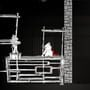

In [193]:
topil = transforms.ToPILImage()
topil(next(iter(train_dataloader))[0][0])

In [194]:
folder = os.path.join('data','screenshots')
labels_map = pd.read_csv(os.path.join(folder,'genre_labels.csv'))
labels_map = labels_map.to_dict()['genre']

In [195]:
class Net(nn.Module):
    def __init__(self, labels_map):
        super(Net, self).__init__()
        self.apply(self._initialize_weights)
        num_classes = len(labels_map)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.fc1 = nn.Linear(16 * 19 * 19, 200)  
        self.fc2 = nn.Linear(200, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x.float())))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                init.zeros_(layer.bias)

model = Net(labels_map=labels_map)

In [196]:
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5776, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=21, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [197]:
def train_loop(dataloader, model, loss_fn, optimizer):
  
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device).long()

    optimizer.zero_grad()

    pred = model(X)



    loss = loss_fn(pred, y.squeeze(1))

    loss.backward()
    
    optimizer.step()

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)

      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  return 100*correct

In [198]:
learning_rate = 1e-4
batch_size = 16
epochs = 20

In [199]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    accuracies.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------


KeyboardInterrupt: 